# Using K-means clustering to reduce image colors

An intuitive example of how you can use K-means clustering to reduce feature size is by using images as an example. An image when stored on a computer is a collection of pixels. Each of those pixels has a particular color. There are several ways to store color data, but for JPEG files data is stored in RGB values. These values have 8 bits, or a range from 0 to 255. This means a pixel can have a value between 0 and 255 for red, a value between 0 and 255 for green, and a value between 0 and 255 for blue. This means a single pixel can have any of 256 * 256 * 256 = 16.777.216 possible colors. Of course, any given picture only has subset of those. 

There are many ways to compress a picture, with or without losing any information, and those are out of scope for this notebook. 

What I want to show you in this notebook, is that it is possible to vastly reduce the number of colors used in a picture (comparable to reducing the number of features) while retaining the informative value of the original picture (you still recognise it as the same picture).

As a note - the Plotly3d plots will not display properly on Github, so clone the repo and run locally if you want to see them :-)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly
import plotly.graph_objs as go
import os
from IPython.display import Image

I have provided several images that you can try the reduction on. They're all in original quality and size. Below you can find the settings to use. You can find the images that are available in the github repo below. 

In [30]:
## Setup
k = 64  #This is the amount of colors to encode the picture to.
img_file = 'havana.jpg' # This is the image to work with, see below list
path_to_img = 'data/images/' #This is the relative path to the image

print(os.listdir(path_to_img))

['balloons.jpg', 'cuba.jpg', 'dog.jpg', 'havana.jpg', 'ny.jpg', 'pubg.jpg', 'rose.jpg', 'sky.jpg', 'sunset.jpg', 'tea.jpg', 'tuktuk.jpg']


The base example is a foto from Havana, with a lot of different colors in them. Change the code after img_file= here above to another picture if you want try another. Or add your own in the data/images/ folder. 

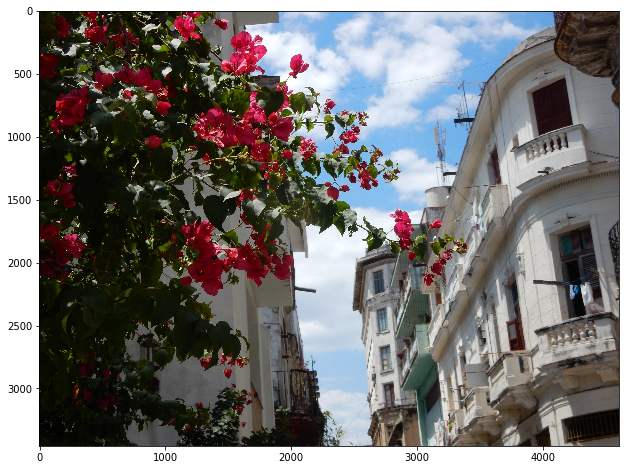

In [31]:
img=mpimg.imread(path_to_img + img_file)
plt.figure(figsize=(12,8))
imgplot = plt.imshow(img)

In [32]:
print(img.shape)

(3456, 4608, 3)


The picture consists of 3456 pixels vertically and 4608 horizontally. If it were stored in the .bmp or bitmap format, this would take up over 47 megabytes. 

In [33]:
#y, x, rgb
n_pixels = img.shape[0] * img.shape[1]
print(n_pixels)

15925248


In total there are 15.9 million pixels. Each of those pixels has an R, G and B value.

In [34]:
## Contents of the topleft pixel
print(img[0,0])

[142 140 127]


For this notebook, I won't use the position the pixel is in as part of the reduction process. I am only interested in clustering colors based on their RGB values and how often they appear in the image.

In [35]:
## Take out the y, x coordinates, we're only interested in RGB.
pixels = pd.DataFrame(img.reshape((n_pixels,3)), columns=['r', 'g', 'b'])
pixels.head()

,r,g,b
0,142,140,127
1,131,129,116
2,75,73,60
3,33,29,18
4,65,61,50


After reshaping the dataframe from (3456, 4608, 3) to (15925248, 3) the first five rows show all different color values. Let's see how many unique colors are in this particular picture:

In [36]:
print(pixels.drop_duplicates().shape)

(435159, 3)


In total, out of the possible colorspace of 16.7 million, in this particular picture 435.159 are used, or 2.5% of the total colorspace.

## Exploring the colors of the picture

Before I move into clustering, first I will do a bit of data exploration. Each of the color values of RGB will have a particular distribution. Exploring the observed distribution will help form an idea of what's going on in the colorspace.

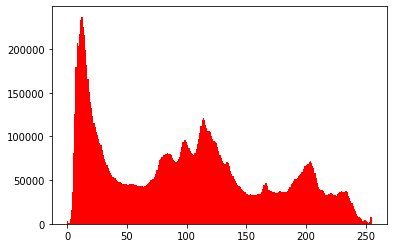

In [37]:
# Red histogram
n, bins, patches = plt.hist(pixels.r, 256, facecolor='r')

Looking at the distribution of red values in the picture, we see a strong peak at low red values, and several smaller peaks at medium and higher levels. 

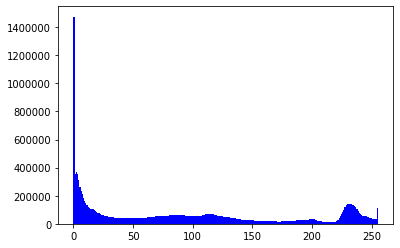

In [38]:
# Blue histogram
n, bins, patches = plt.hist(pixels.b, 256, facecolor='b')

For blue values I see most pixels in the picture have no blue in it, but also a peak at higher intensities.

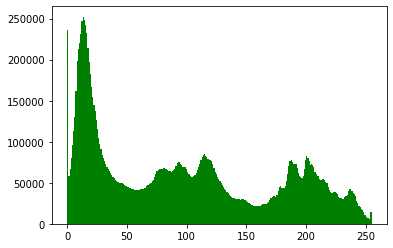

In [39]:
# Green histogram
n, bins, patches = plt.hist(pixels.g, 256, facecolor='g')

And the green values look relatively similar to the red values. One would expect the green and red peaks to appear on the same pixels. That would provide shades of yellow however, and the original picture is missing that color.

## Exploring color combinations in the picture

In order to dive deeper into what's going on, I combine two colors in a scatterplot. However, as the number of pixels is huge (over 15 million) I sample one percent out of the picture. 

In [40]:
# Sample the dataset. 
sample = pixels.sample(frac=0.01)

def rgb_to_hex(s):
    return '#%02x%02x%02x' % (s['r'], s['g'], s['b']) 
orig_colors = sample.apply(rgb_to_hex, axis=1)

print(sample.shape)

(159252, 3)


This makes the number of pixels much easier to see in a scatterplot.

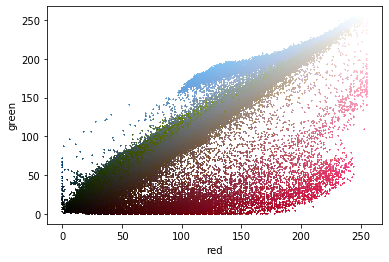

In [41]:
plt.scatter(sample.r, sample.g, s=1, marker="+", c=orig_colors)
plt.xlabel('red')
plt.ylabel('green')
plt.show()

A bright red smudge on the bottom right probably contains the red from the roses. It is also possible to see the diagonal line from black to white, but if you look closely you can see on the green side part of the green leaves. Also part of the sky apparrently contains a bit of red and green as well.

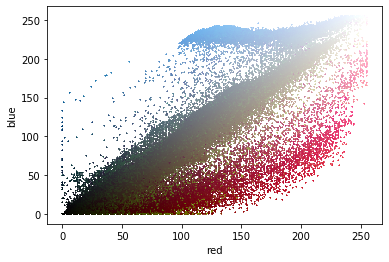

In [42]:
plt.scatter(sample.r, sample.b, s=1, marker="+", c=orig_colors)
plt.xlabel('red')
plt.ylabel('blue')
plt.show()

Plotting red vs blue shows a similar pattern. The sky pixels obviously contain a lot of blue, and the whiter they are, the more red they contain as well. This is logical, considering white contains all three colors.

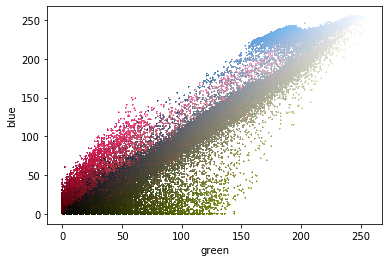

In [43]:
plt.scatter(sample.g, sample.b, s=1, marker="+", c=orig_colors)
plt.xlabel('green')
plt.ylabel('blue')
plt.show()

Finally, in the plot between green and blue, I see that the red pixels of the roses contain little of either. There are no pixels with high blue values and low green values, or vice versa. 

## 3d plot exploration

The above 2d scatterplots give more insight in how the color space is populated, but it is still difficult to get the full grasp on it. A 3d plot will help a lot. This way you can rotate and explore it much better.

In [ ]:
plotly.offline.init_notebook_mode()

trace = go.Scatter3d(
    x=sample.r,  
    y=sample.g,  
    z=sample.b,  
    mode='markers',
    marker={
        'size': 2,
        'opacity': .25,
        'color': orig_colors
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene=dict(
    xaxis={'title':'Red'},
    yaxis={'title':'Green'},
    zaxis={'title':'Blue'}
        )
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plotly.offline.iplot(plot_figure)

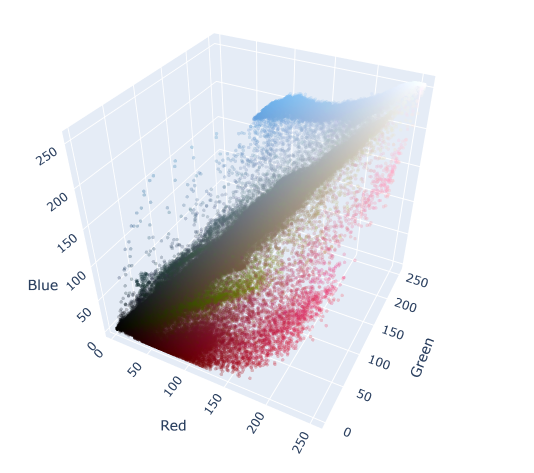

In [103]:
##Show sample image on Github:
Image(filename="inline_images/orig.png")

*this is just a sample image for the plot above*

Try rotating the above picture to see how the colorspace is populated. There is the "black-to-white" axis from (0,0,0) to (255,255,255) which is richly populated in the picture. And it is possible to see 'waves' of red from the flowers, light blue from the sky, and dark green from the leaves. Other colors are missing. 

## Calculating the k-means centers

As I consider each color intensity to be equally important for the clustering, I don't need to work further on preparing the data. At the beginning of the notebook, I defined the number of colors to encode to as k, which I'll use here to cluster the image on. 

In [44]:
## Apply kmeans to the sample data (faster, still representative)
kmeans = KMeans(n_clusters=k)
kmeans.fit(sample)

## Apply the clustering to the sample
sample_new_colors = kmeans.predict(sample)
centroids = pd.DataFrame(kmeans.cluster_centers_.round().astype('uint8'), columns=('r', 'g', 'b'))
rgb_colors = centroids.apply(rgb_to_hex, axis=1)

## Show the centroids
print(centroids)

      r    g    b
0   216  225  240
1    85   85   83
2    28   27   20
3   128  131  132
4   132  187  235
..  ...  ...  ...
59  108  144  184
60   36   46   46
61  221   55  103
62   78  101  114
63   29   32    3

[64 rows x 3 columns]


The above list shows the determined centroids. For any pixel, the color will be changed to the color of the nearest centroid.

## Examining the clusters


First, I look at the place and position of the clusters in the 2d scatterplots.

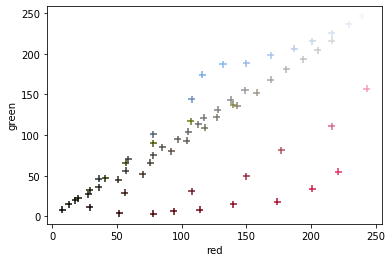

In [45]:
plt.scatter(centroids.r, centroids.g, s=50, marker="+", c=rgb_colors)
plt.xlabel('red')
plt.ylabel('green')
plt.show()

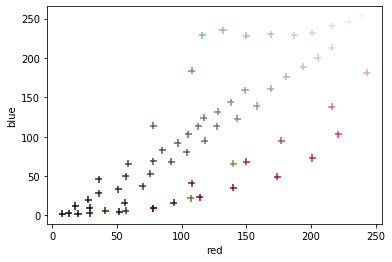

In [46]:
plt.scatter(centroids.r, centroids.b, s=50, marker="+", c=rgb_colors)
plt.xlabel('red')
plt.ylabel('blue')
plt.show()

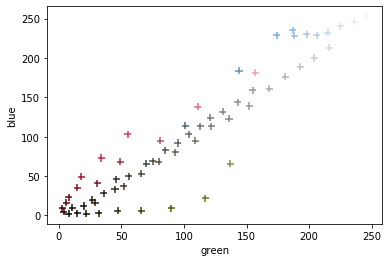

In [47]:
plt.scatter(centroids.g, centroids.b, s=50, marker="+", c=rgb_colors)
plt.xlabel('green')
plt.ylabel('blue')
plt.show()

The same structure as in the original 2d plots is visible. Most interesting to see if the sepearation between gray and brown gradients in the diagonal.

Secondly I look at the place and position of the identified clusters in the 3d scatterplot.

In [ ]:
plotly.offline.init_notebook_mode()

trace = go.Scatter3d(
    x=centroids.r,  
    y=centroids.g,  
    z=centroids.b, 
    
    mode='markers',
    marker={
        'size': 10,
        'opacity': 1,
        'color':rgb_colors
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene=dict(
    xaxis={'title':'Red'},
    yaxis={'title':'Green'},
    zaxis={'title':'Blue'}
        )
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plotly.offline.iplot(plot_figure)

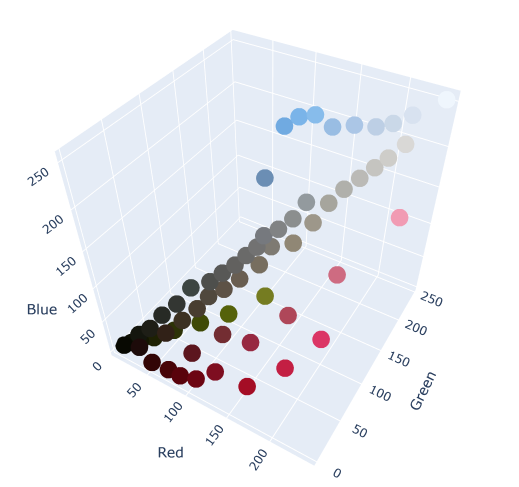

In [104]:
##Show sample image on Github:
Image(filename="inline_images/clusters.png")

*this is just a sample image for the plot above*

In the example with 64 clusters, several interesting things are visible. To me, the most interesting thing I noticed was that in the brown/gray area of the color spectrum, two series of clusters run close side by side. Other than that, the structure as could be seen in the explorative scatterplot, with the large red point cloud comign from the roses, and the slight blue structure near white / blue from the clouds are also well reflected with the plot.

Next I look at the pixels themselves, and the newly recoded colors. This is the application of the above centroids to the pixels. 

In [ ]:
plotly.offline.init_notebook_mode()

trace = go.Scatter3d(
    x=sample.r,  # <-- Put your data instead
    y=sample.g,  # <-- Put your data instead
    z=sample.b,  # <-- Put your data instead
    
    mode='markers',
    marker={
        'size': 2,
        'opacity': .25,
        'color':rgb_colors[sample_new_colors]
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene=dict(
    xaxis={'title':'Red'},
    yaxis={'title':'Green'},
    zaxis={'title':'Blue'}
        )
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

plotly.offline.iplot(plot_figure)

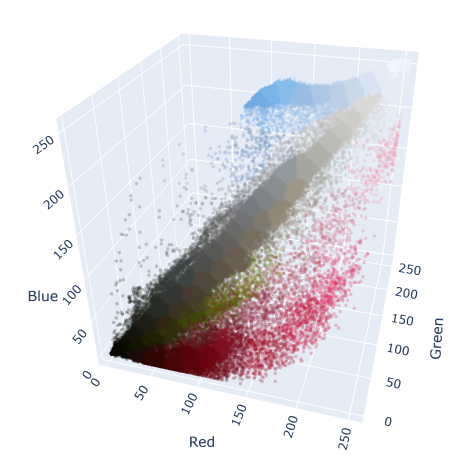

In [105]:
##Show sample image on Github:
Image(filename="inline_images/recoded.png")

*this is just a sample image for the plot above*

The gradients for gray and brown are easily visible from this plot.

## Creating the colorcoded picture.

The previous plots were all on the sample of 1% of the original picture. In order to create the color coded picture, the k-means model needs to be used on all of original pixels.

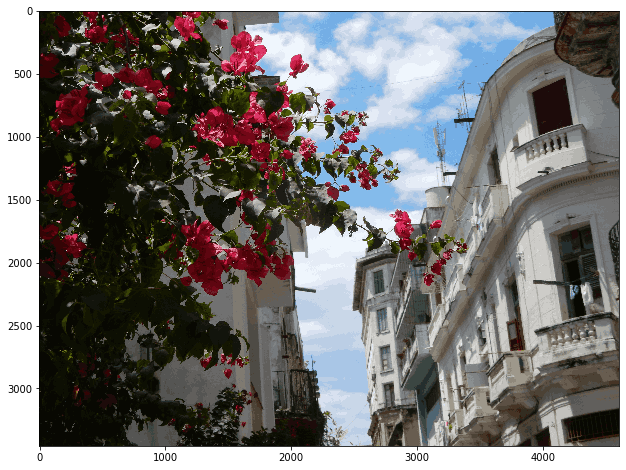

In [48]:
# Encode total image and show
new_colors = kmeans.predict(pixels)
new_img = np.array(centroids.iloc[new_colors, :]).reshape(img.shape)
plt.figure(figsize=(12,8))
imgplot = plt.imshow(new_img)
plt.imsave('data/output/'+str(k)+'_'+img_file, new_img)

Using k=64, a picture quite similar to the original is shown. At certain spots, it is also easily visible some information is lost (such as the clouds), but at the same time, it is still easily recognisable as the original image.

The below snippet of code you can use to do the above steps for one image with multiple values of k. Just plug in the values you would like to see where k_range is written.

In [ ]:
def colorcode(img_in, img_out, k):
    img=mpimg.imread(img_in)
    n_pixels = img.shape[0] * img.shape[1]
    pixels = pd.DataFrame(img.reshape((n_pixels,3)), columns=['r', 'g', 'b'])
    sample = pixels.sample(frac=0.01)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(sample)
    sample_labels = kmeans.predict(sample)
    centroids = kmeans.cluster_centers_
    centroids = pd.DataFrame(centroids.astype('uint8'), columns=('r', 'g', 'b'))
    new_labels = kmeans.predict(pixels)
    new_img = np.array(centroids.iloc[new_labels, :]).reshape(img.shape)
    silhouette = silhouette_score(sample, sample_labels)
    plt.imsave(img_out, new_img)
    
    return new_img, silhouette, centroids

In [ ]:
img_file = 'havana.jpg' # This is the image to work with, see below list
path_to_img = 'data/images/' #This is the relative path to the image
img_path = path_to_img + img_file
k_range = [2,3,4]
for k in k_range:
    print(k)
    out_path =  'data/output/'+ str(k) + '_' + img_file
    img, sil, cen = colorcode(img_path, out_path, k)
    print(sil)
    